## Unveiling the Crystal Record of Volcanic Eruptions by Unsupervised Learning

### Problem Definition

In this Jupyter Notebook, we aim to replicate the results obtained through Clustering and Dimensionality Reduction techniques as reported by Musu et al. (2023) in their manuscript, 'The Magmatic Evolution of South-East Crater (Mt. Etna) During the February–April 2021 Sequence of Lava Fountains from a Mineral Chemistry Perspective.' Specifically, Musu et al. (2023) focused on the clinopyroxene phase to unveil the pre-eruptive dynamics at Mt. Etna volcano.

Musu A., Corsaro R.A., Higgins O., Jorgenson C., Petrelli M., and Caricchi L.  (2023). The magmatic evolution of South-East Crater (Mt. Etna) during the February–April 2021 sequence of lava fountains from a mineral chemistry perspective. _Bull Volcanol_ __85__, 33. https://doi.org/10.1007/s00445-023-01643-2

### The Data Set

The data set consists of 1250 major element determinations on clinopyroxene crystals acquired by an Electron Probe Micro-Analyzer (EPMA) at the University of Geneva. The data are stored in a text file named "ETN21_cpx_all.txt" 

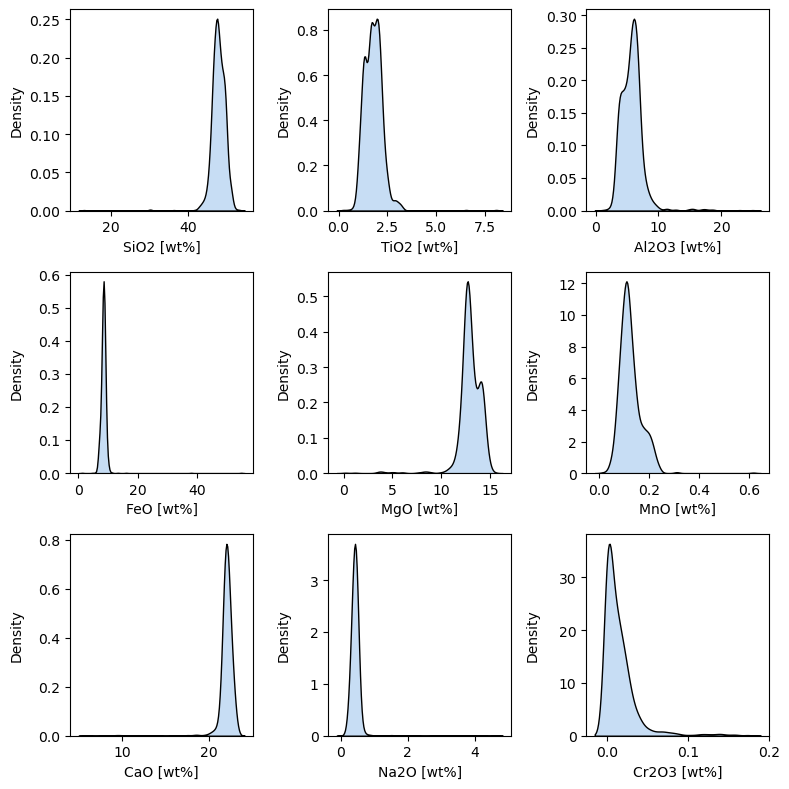

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

my_dataset = pd.read_table('ETN21_cpx_all.txt')

oxides  = ['SiO2', 'TiO2', 'Al2O3', 
            'FeO', 'MgO', 'MnO', 'CaO', 'Na2O','Cr2O3']


fig = plt.figure(figsize=(8,8))
for i, oxide in enumerate(oxides):
    ax1 = fig.add_subplot(3, 3, i+1)
    sns.kdeplot(my_dataset[oxide],fill=True, 
                color='k', facecolor='#c7ddf4', ax = ax1)
    ax1.set_xlabel(oxide + " [wt%]")
fig.align_ylabels()
fig.tight_layout()

### Data Pre-Processing

The data pre-processing strategy consisted of: 1) data cleaning to remove outliers; 2) CoDA transformation; 3) Data scaling.

#### Data Cleaning

The first step of data cleaning consisted of removing those analyses where the sum of EPMA-determined oxides was less than 98 and greater than 102.

In [2]:
my_dataset = my_dataset[(my_dataset.Total>98) & 
                        (my_dataset.Total<102)]

In the second step of data cleaning, Musu et al. (2021) transformed EPMA determinations from oxides to cations on the mineral structure based on 4 cations and 6 oxygens. Then, they removed that occurrence where the estimated cations were above 4.06 or below 3.94.  

In [3]:
def calc_cations_on_oxygen_basis(myData0, my_ph, my_el, n_ox):
    Weights = {
        'SiO2': [60.0843,1.0,2.0], 'TiO2':[79.8788,1.0,2.0], 
        'Al2O3': [101.961,2.0,3.0],'FeO':[71.8464,1.0,1.0], 
        'MgO':[40.3044,1.0,1.0], 'MnO':[70.9375,1.0,1.0], 
        'CaO':[56.0774,1.0,1.0], 'Na2O':[61.9789,2.0,1.0],
        'K2O':[94.196,2.0,1.0], 'Cr2O3':[151.9982,2.0,3.0],
        'P2O5':[141.937,2.0,5.0], 'H2O':[18.01388,2.0,1.0]}
    myData = myData0.copy()
    myData = myData.add_prefix(my_ph + '_')
    for el in my_el: # Cation mole proportions
        myData[el + '_cat_mol_prop'] = myData[my_ph + 
                '_' + el] * Weights[el][1] / Weights[el][0]   
    for el in my_el:  # Oxygen mole proportions
        myData[el + '_oxy_mol_prop'] = myData[my_ph + 
                '_' + el] * Weights[el][2] / Weights[el][0]
    totals = np.zeros(len(myData.index)) # Ox mole prop tot
    for el in my_el:
        totals += myData[el + '_oxy_mol_prop']
    myData['tot_oxy_prop'] = totals
    totals = np.zeros(len(myData.index)) # totcations
    for el in my_el:
        myData[el + '_num_cat'] = n_ox * myData[el + 
                    '_cat_mol_prop']  /  myData['tot_oxy_prop']
        totals += myData[el + '_num_cat']
    return totals


Cat_Ox_Tolerance = {'cpx':  [4,6,0.06]}

my_dataset['Tot_cations'] = calc_cations_on_oxygen_basis(
            myData0 = my_dataset, 
            my_ph = 'cpx', 
            my_el = oxides, 
            n_ox = Cat_Ox_Tolerance['cpx'][1])

my_dataset = my_dataset[(
    my_dataset['Tot_cations'] < Cat_Ox_Tolerance['cpx'][0] + 
    Cat_Ox_Tolerance['cpx'][2])&(
    my_dataset['Tot_cations'] > Cat_Ox_Tolerance['cpx'][0] - 
    Cat_Ox_Tolerance['cpx'][2])]


The third and final step of data cleaning consisted of selecting a limited set of elements (i.e., SiO$_2$, TiO$_2$, Al$_2$O$_3$, FeO, MgO, CaO, and Na$_2$O), and removing those observations that were below the 1st and above 99th percentiles, respectively, considered as outliers.

In [4]:
elms_for_clustering  = ['SiO2', 'TiO2', 
            'Al2O3', 'FeO', 'MgO', 'CaO', 'Na2O']

my_dataset = my_dataset[elms_for_clustering]

my_dataset = my_dataset[~((
    my_dataset < my_dataset.quantile(0.001)) | 
   (my_dataset > my_dataset.quantile(0.999))).any(axis=1)]

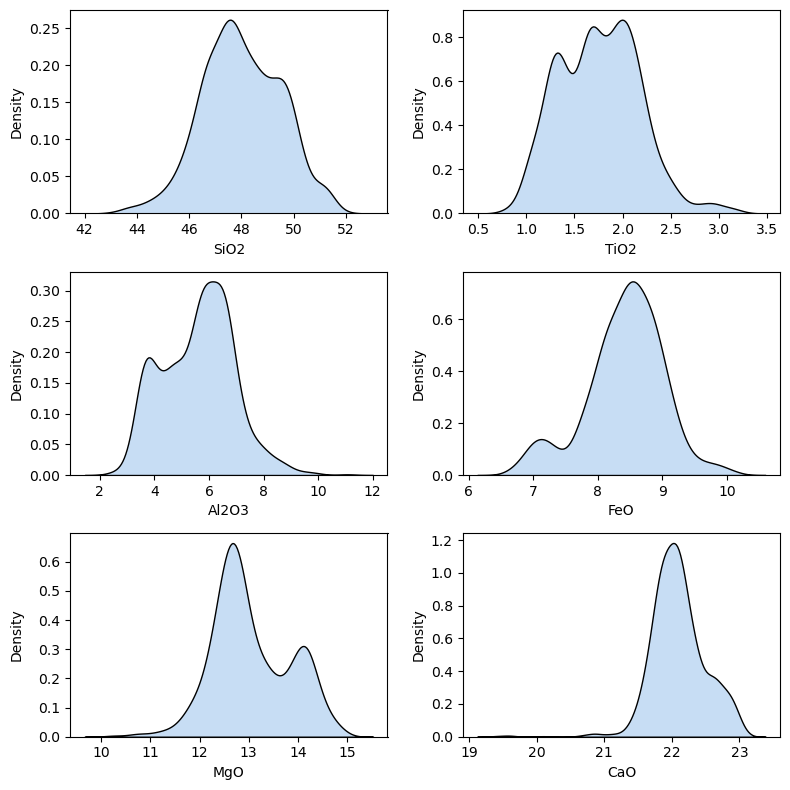

In [5]:
fig = plt.figure(figsize=(8,8))
for i in range(0,6):
    ax1 = fig.add_subplot(3, 2, i+1)
    sns.kdeplot(my_dataset[elms_for_clustering[i]],fill=True, 
                color='k', facecolor='#c7ddf4', ax = ax1)
    ax1.set_xlabel(elms_for_clustering[i])
fig.align_ylabels()
fig.tight_layout()

#### CoDA transformation

Chemical determinations by EPMA (Electron Probe Micro-Analyser) of clinopyroxenes yield compositions close to 100 wt%. These results define a simplex in the compositional space, indicating that the compositional data must be treated using Compositional Data Analysis (CoDa) techniques (e.g., Greenacre, 2021). This approach is essential to appropriately address the closure problem and analyze the data in a statistically valid way, ensuring an accurate interpretation of the mineral chemistry. In this specific case, Musu et al. (2021) adopted the isometric log-ratio (ilr) transformation. Ilr works by taking the logarithm of ratios of geometric means of parts of the composition. Specifically, the ilr transformation involves:

a) Partitioning the components of the composition into mutually exclusive groups.
b) Calculating the geometric mean within each group.
c) Taking the logarithm of the ratio of these geometric means, ensuring the transformed values are not constrained by the constant sum.

The ilr transformation results in data that are unconstrained (not bound to sum up to a constant) and can be analyzed using conventional statistical methods, such as clustering investigations, PCA (Principal Component Analysis), and correlation analysis. The transformation is "isometric" in the sense that it preserves the distances and relationships between points in the original compositional space, allowing for meaningful interpretation of the results in the context of the original compositional data (REF). In our example, we utilized the ilr transformation implemented in [scikit-bio](https://scikit.bio/index.html).

Greenacre, M. (2021). Compositional Data Analysis. _Annual Review of Statistics and Its Application_ __8__, 271-299. 
https://doi.org/10.1146/annurev-statistics-042720-124436

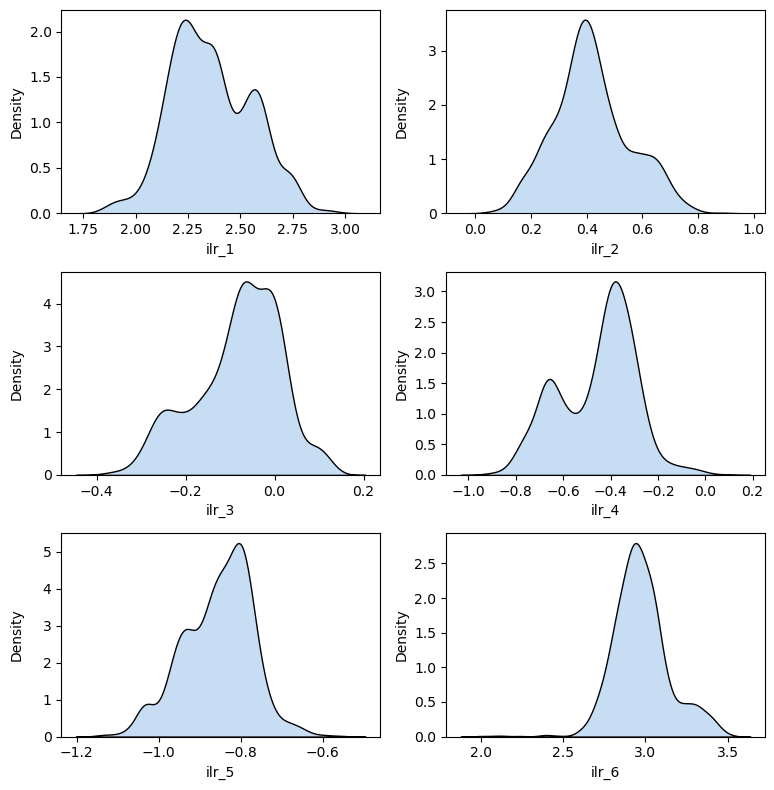

In [6]:
from skbio.stats.composition import ilr

my_dataset_ilr = ilr(my_dataset)

fig = plt.figure(figsize=(8,8))

for i in range(0,6):
    ax1 = fig.add_subplot(3, 2, i+1)
    sns.kdeplot(my_dataset_ilr[:, i],fill=True, 
                color='k', facecolor='#c7ddf4', ax = ax1)
    ax1.set_xlabel('ilr_' + str(i+1))
fig.align_ylabels()
fig.tight_layout()

#### Data scaling

For data scaling, we use the [RobustScaler](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py) implemented in scikit-learn.

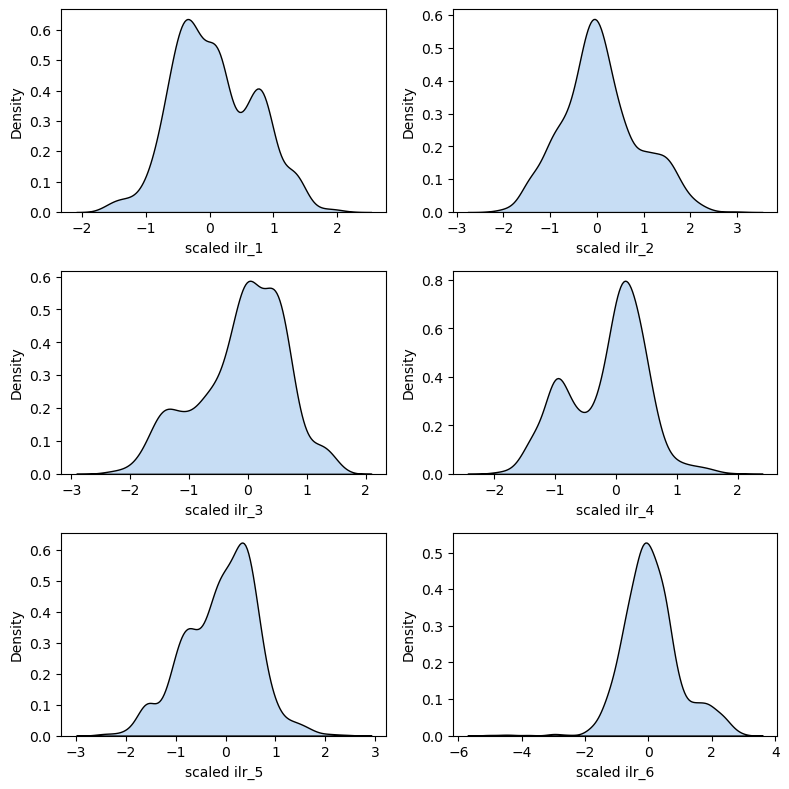

In [7]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler(
    quantile_range=(25.0, 75.0)).fit(my_dataset_ilr)

my_dataset_ilr_scaled = transformer.transform(my_dataset_ilr)

my_dataset_ilr_scaled = my_dataset_ilr_scaled 
fig = plt.figure(figsize=(8,8))

for i in range(0,6):
    ax1 = fig.add_subplot(3, 2, i+1)
    sns.kdeplot(my_dataset_ilr_scaled[:, i],fill=True, 
                color='k', facecolor='#c7ddf4', ax = ax1)
    ax1.set_xlabel('scaled ilr_' + str(i+1))
fig.align_ylabels()
fig.tight_layout()

### Hierarchical Clustering

Hierarchical clustering is a method of cluster analysis based on two main approaches: (a) Agglomerative and (b) Divisive.

The Agglomerative, or bottom-up approach, is the most common strategy to perform hierarchical clustering. It starts by considering each observation as a cluster. Then, pairs of clusters are merged as one moves up the hierarchy, based on their distance (or similarity), until all points are merged into a single cluster.
On the contrary, the divisive, or top-down approach, starts considering all the data points as a single cluster. Then, the cluster is divided into smaller clusters, progressively, until each data point becomes a single cluster.

The two main parameters that govern the outcomes of the hierarchical clustering are the distance measure (such as Euclidean distance, Manhattan distance, etc.) and the linkage criterion (such as single linkage, complete linkage, average linkage, etc.). They are used to calculate the similarities between observations and to provide a criterion to aggregate (or disaggregate) different clusters, respectively.

The outcomes of the hierarchical clustering are usually represented as a dendrogram, a tree-like diagram illustrating the arrangement of the clusters produced by the hierarchical clustering.

In [8]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette

def plot_dendrogram(model, **kwargs): 
    # more dtails on https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, 
                                      model.distances_,
                                     counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(linkage='ward',  
                                metric='euclidean',
                                distance_threshold = 0, 
                                n_clusters=None)

model.fit(my_dataset_ilr_scaled)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

## Plotting the Dendogram

We start plotting the agglomerative hierarchical clustering model by limiting the visualization to five levels. To do that, we fix the _truncate_mode_ and _p_ parameters to 'level' and 5, respectively. 

Text(0, 0.5, 'Height')

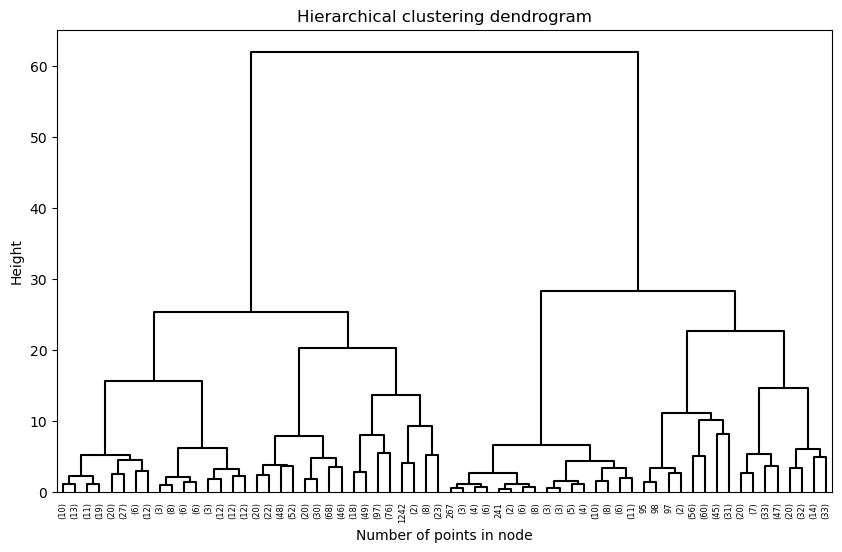

In [9]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Hierarchical clustering dendrogram')

plot_dendrogram(model, truncate_mode='level', p=5, 
                color_threshold=0, 
                above_threshold_color='black')

ax.set_xlabel('Number of points in node')
ax.set_ylabel('Height')

We repeat the operation. In this case, we also define a color threshold, to a value of 16.5.

Text(0.5, 0, 'Number of points in node')

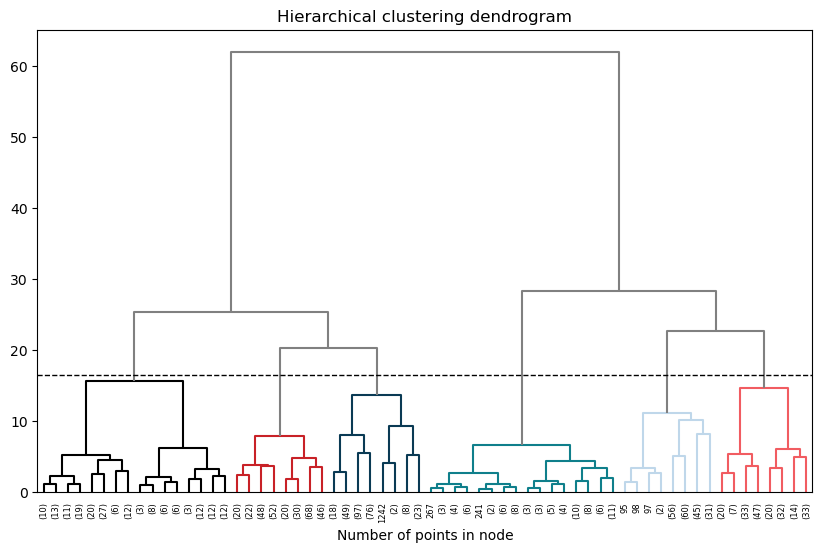

In [10]:
th = 16.5
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title("Hierarchical clustering dendrogram")
set_link_color_palette(['#000000','#C82127', '#0A3A54',
            '#0F7F8B', '#BFD7EA', '#F15C61', '#E8BFE7'])

plot_dendrogram(model, truncate_mode='level', p=5, 
                color_threshold=th, 
                above_threshold_color='grey')

plt.axhline(y = th, color = "k", linestyle = "--", lw=1)
ax.set_xlabel("Number of points in node")



Finally, we set _truncate_mode_ and _p_ to 'lastp' and 6, respectively. The resulting dendrogram will truncate the plotting to six non-singleton clusters. Non-singleton means that the cluster contains more than one obesrvation.

Text(0.5, 0, 'Number of points in node')

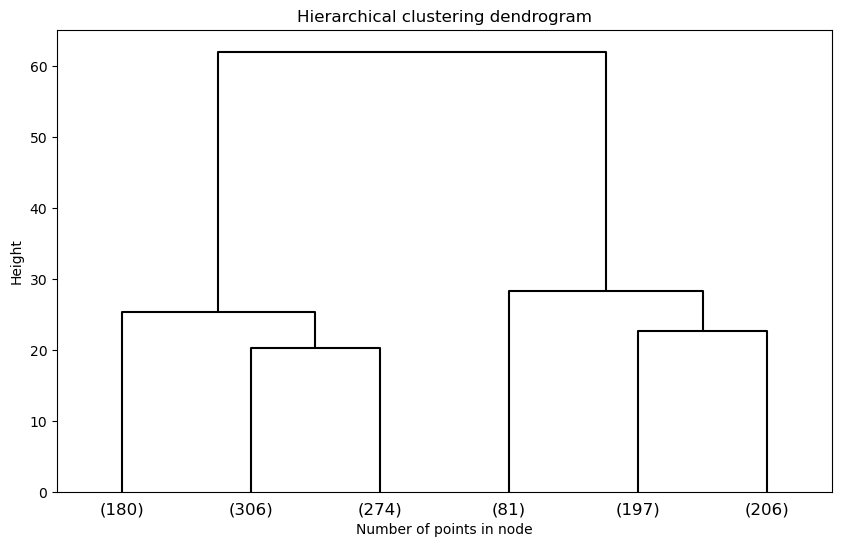

In [11]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title("Hierarchical clustering dendrogram")
ax.set_ylabel('Height')

plot_dendrogram(model, truncate_mode='lastp', p=6, 
                color_threshold=0, 
                above_threshold_color='k')

ax.set_xlabel("Number of points in node")

### Principal Component Analysis

Principal Component Analysis (PCA) is a statistical technique that uses an orthogonal transformation to convert a set of observations of possibly correlated features into a set of values of linearly uncorrelated variables called principal components (e.g., Greenacre et al., 2022). This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component, in turn, has the highest variance possible under the constraint that it is orthogonal to (i.e., uncorrelated with) the preceding components. the PCA is particularly useful when you need to reduce the dimensionality of data with many variables while retaining as much variance in the data as possible. This dimensionality reduction aims at simplifying the visualization of complex data while preserving the structural relationships in the data set.

Greenacre, M., Groenen, P.J.F., Hastie, T. et al. (2022). Principal component analysis. _Nat Rev Methods Primers_ __2__, 100. https://doi.org/10.1038/s43586-022-00184-w

Text(0, 0.5, 'PC_2')

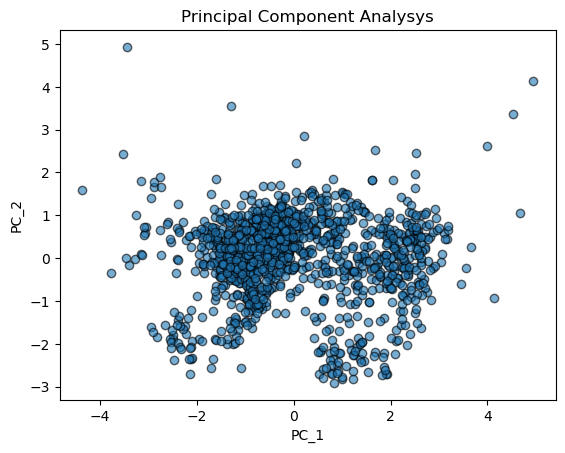

In [12]:
from sklearn.decomposition import PCA

#PCA
model_PCA = PCA()
model_PCA.fit(my_dataset_ilr_scaled)
my_PCA = model_PCA.transform(my_dataset_ilr_scaled)

fig, ax = plt.subplots()

ax.scatter(my_PCA[:,0], my_PCA[:,1], 
           alpha=0.6, 
           edgecolors='k')

ax.set_title('Principal Component Analysys')
ax.set_xlabel('PC_1')
ax.set_ylabel('PC_2')

### Principal Component Analysis Combined with Hierarchical Clustering

Now, we are going to plot the results of the PCA as above, but coloring the observations in agreement with the outcomes from the hierarchical clustering.

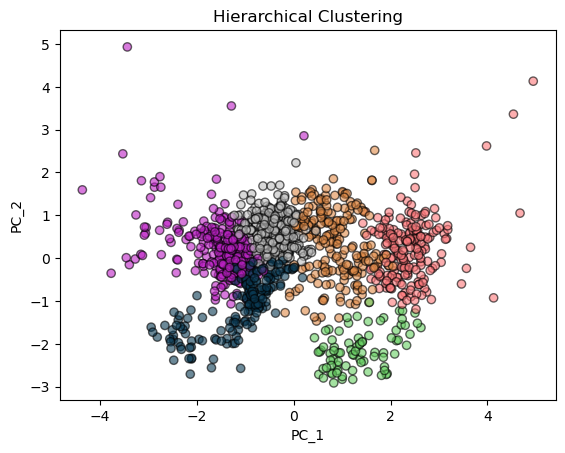

In [13]:
my_colors = {0:'#0A3A54', 
          1:'#E08B48',
          2:'#BFBFBF', 
          3:'#BD22C6', 
          4:'#FD787B',
          5:'#67CF62' }

#AgglomerativeClustering
model_AC = AgglomerativeClustering(linkage='ward',  
                                metric='euclidean',
                                n_clusters=6)

my_AC = model_AC.fit(my_dataset_ilr_scaled)

fig, ax = plt.subplots()
label_to_color = [my_colors[i] for i in my_AC.labels_]
ax.scatter(my_PCA[:,0], my_PCA[:,1], 
           c=label_to_color, alpha=0.6, 
           edgecolors='k')
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('PC_1')
ax.set_ylabel('PC_2')
my_dataset['cluster_HC'] = my_AC.labels_

### Principal Component Analysis Combined with K-Means Clustering

The same as above, but using the K-means algorithm to define six clusters.

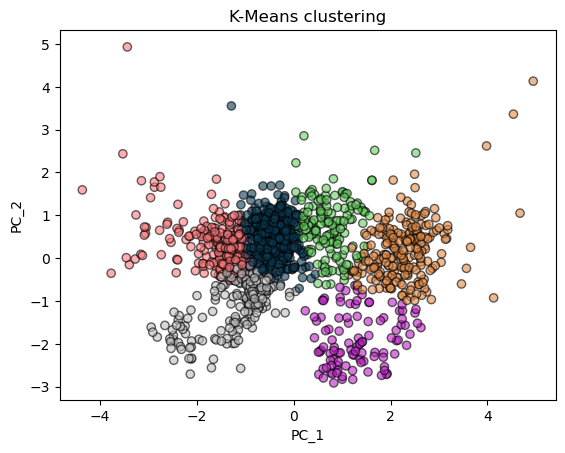

In [14]:
#KMeans
from sklearn.cluster import KMeans
myKM = KMeans(n_clusters=6, n_init=10).fit(my_dataset_ilr_scaled)

fig, ax = plt.subplots()
label_to_color = [my_colors[i] for i in myKM.labels_]
ax.scatter(my_PCA[:,0], my_PCA[:,1], 
           c=label_to_color, alpha=0.6, 
           edgecolors='k')
ax.set_title('K-Means clustering')
ax.set_xlabel('PC_1')
ax.set_ylabel('PC_2')
my_dataset['cluster_KM'] = myKM.labels_

### Final Remarks

Musu et al. (2021) reported that leveraging CoDA transformation and normalization techniques in conjunction with Hierarchical Clustering analysis and Dimensional Reduction techniques (e.g., PCA) on geochemical datasets serves as an effective method for delineating clusters of minerals with similar chemical and textural characteristics. In the case of clinopyroxene, this approach revealed six distinct clusters (CL1-CL6) throughout the Etna eruption sequence from February 16 to April 1. CL3, CL4, and CL6 corresponded to hourglass zones, while CL1, CL2, and CL5 were associated with prism sectors and concentric zoning. Notably, CL2 and CL5 were indicative of a more mafic composition, showing a proportional increase leading up to the February 28 eruptive event, followed by a subsequent decline.